<a href="https://colab.research.google.com/github/Taiga10969/MPRG_Lecture_Notebook_update/blob/main/vlm/VLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLIPと言語モデルを組み合わせたVLMモデル**
ここでは，CLIPの画像エンコーダと言語モデルを組み合わせて，VLM（Vision Language Model）を構築します．
<br>
<br>
本演習は実行に約30分程度かかります．（T4 GPU, 2エポック学習時）

## 準備

### 必要パッケージのインストールとモジュールのインポート

In [1]:
# 必要パッケージのインストール（2分程度かかります）
!pip install -q git+https://github.com/openai/CLIP.git > /dev/null
!pip install -q torchinfo
!pip install -q nltk

In [2]:
import json
import json, random
from pathlib import Path
import random
import os
import json, os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
import torchvision
import clip
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from tqdm import tqdm
from torchinfo import summary
import math
from torch.optim import AdamW
from tqdm import tqdm
import torch
from transformers import GPT2LMHeadModel
import json
from pathlib import Path
from typing import List, Dict, Any, Optional, Literal

from PIL import Image
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import transforms
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


---
## **各モデルの確認**
はじめに，CLIPの画像エンコーダとGPT-2のそれぞれのモデルについて理解します．

###  **CLIPの画像エンコーダ**
CLIPの画像エンコーダについて，モデルの構造や挙動を確認します．

In [3]:
# CLIPの学習済みモデルの用意
model, preprocess = clip.load('ViT-L/14', "cpu")
image_encoder = model.visual
summary(image_encoder)

Layer (type:depth-idx)                                            Param #
VisionTransformer                                                 1,050,624
├─Conv2d: 1-1                                                     602,112
├─LayerNorm: 1-2                                                  2,048
├─Transformer: 1-3                                                --
│    └─Sequential: 2-1                                            --
│    │    └─ResidualAttentionBlock: 3-1                           12,596,224
│    │    └─ResidualAttentionBlock: 3-2                           12,596,224
│    │    └─ResidualAttentionBlock: 3-3                           12,596,224
│    │    └─ResidualAttentionBlock: 3-4                           12,596,224
│    │    └─ResidualAttentionBlock: 3-5                           12,596,224
│    │    └─ResidualAttentionBlock: 3-6                           12,596,224
│    │    └─ResidualAttentionBlock: 3-7                           12,596,224
│    │    └─ResidualAttenti

これより，CLIPの画像エンコーダを取得できました．<br>
中身を確認すると，VisionTransformerモデルになっていることが確認できます．

### **GPT-2**

In [4]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2Model.from_pretrained('gpt2')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = gpt2_model(**encoded_input)
print(output.last_hidden_state.shape)

tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


torch.Size([1, 10, 768])


---
## **画像キャプション データセット**
**画像キャプションタスク**とは，入力された画像の内容を自然言語の文章で説明するタスクのことです．<br>
英語では Image Captioning と呼ばれ，コンピュータビジョン（CV）と自然言語処理（NLP）の両方の技術を組み合わせた典型的なマルチモーダルなタスクです．

### COCO データセット
COCOデータセット（MS COCO: Microsoft Common Objects in Context）は，
コンピュータビジョン分野で非常によく使われる大規模な画像データセットで，複数のタスクに利用されいています．<br>


| タスク                                         | 説明                | アノテーション形式         |
| ------------------------------------------- | ----------------- | ----------------- |
| **物体検出 (Object Detection)**                 | 画像中の物体の位置とカテゴリを予測 | バウンディングボックス + ラベル |
| **インスタンスセグメンテーション (Instance Segmentation)** | 物体ごとのピクセル単位の領域を予測 | マスク + ラベル         |
| **キーポイント検出 (Keypoint Detection)**           | 人物の関節位置などを予測      | 17個の人体キーポイント      |
| **キャプション生成 (Image Captioning)**             | 画像を説明する自然文を生成     | 画像ごとに5つのキャプション    |




In [5]:
# データセットのダウンロード（1分程度かかります）
!wget -q -O val2017.zip http://images.cocodataset.org/zips/val2017.zip
!wget -q -O annotations_trainval2017.zip http://images.cocodataset.org/annotations/annotations_trainval2017.zip

!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

上記のダウンロード・解凍により，<br>
`/val2017`に画像データ，`/captions_val2017.json`に検証用データに対応したアノテーションデータが格納されたデータを用意できました．<br>
<br>
**⚠️注意**<br>
今回の学習では，リソースの関係で小規模なデータセットで学習を行います．<br>
具体的には，公開されているCOCOデータセットの内，検証用データとして公開されているデータを今回学習に使用する学習用データと検証用データに分割して利用します．
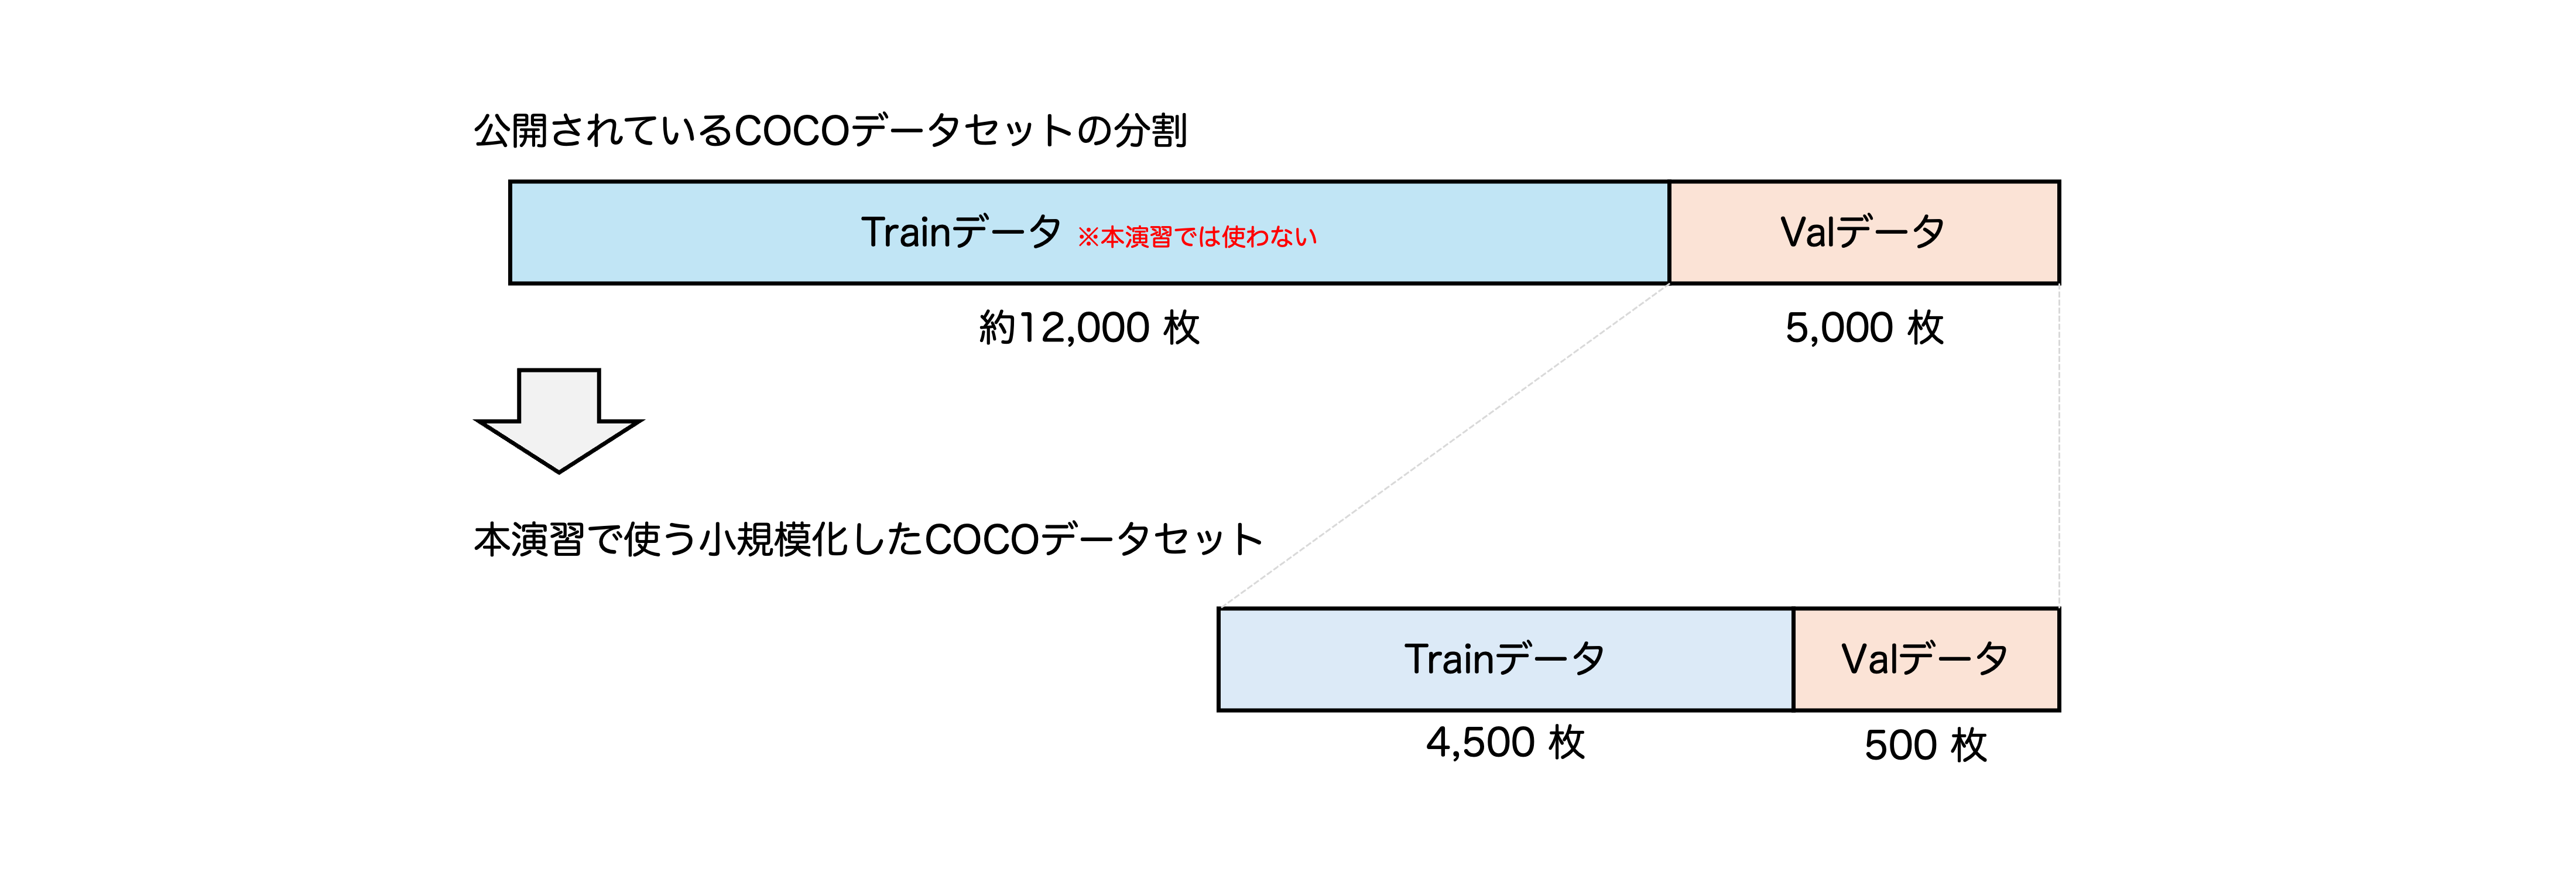

以下のプログラムで小規模化したCOCOデータセットを作成します

In [6]:
ANNOT_PATH = "annotations/captions_val2017.json"
IMG_DIR    = "val2017"

random_seed = 42
# どちらかを使う：1) 枚数指定  2) 比率指定（枚数指定が優先されます）
n_train = None   # 例: 1000枚
n_val   = None    # 例: 200枚
train_ratio = 0.9  # 枚数未指定(None)のときだけ使用


random.seed(random_seed)
with open(ANNOT_PATH, "r") as f:
    coco = json.load(f)

# 画像ID -> file_name
id2file = {img["id"]: img["file_name"] for img in coco["images"]}

# 画像ID -> [captions...]
caps = {}
for ann in coco["annotations"]:
    img_id = ann["image_id"]
    if img_id in id2file:
        caps.setdefault(img_id, []).append(ann["caption"])

valid_img_ids = []
for img_id, file_name in id2file.items():
    if (Path(IMG_DIR) / file_name).exists() and img_id in caps:
        valid_img_ids.append(img_id)

random.shuffle(valid_img_ids)

if n_train is None or n_val is None:
    split_idx = int(len(valid_img_ids) * train_ratio)
    train_ids = set(valid_img_ids[:split_idx])
    val_ids   = set(valid_img_ids[split_idx:])
else:
    need = n_train + n_val
    pool = valid_img_ids if len(valid_img_ids) >= need else valid_img_ids
    train_ids = set(pool[:n_train])
    val_ids   = set(pool[n_train:n_train+n_val])

#assert train_ids.isdisjoint(val_ids), "train と val に同じ画像が混ざっています！"

def make_pairs(selected_ids):
    out = []
    for img_id in selected_ids:
        file_name = id2file[img_id]
        out.append({
            "image": f"{IMG_DIR}/{file_name}",
            "captions": caps.get(img_id, [])
        })
    return out

train_pairs = make_pairs(sorted(train_ids))
val_pairs   = make_pairs(sorted(val_ids))

with open("train_small.json", "w", encoding="utf-8") as f:
    json.dump(train_pairs, f, ensure_ascii=False, indent=2)
with open("val_small.json", "w", encoding="utf-8") as f:
    json.dump(val_pairs, f, ensure_ascii=False, indent=2)

print("Done.")
print(f"train images: {len(train_pairs)}")
print(f"val images:   {len(val_pairs)}")


Done.
train images: 4500
val images:   500


---
## **データセット・データローダーの定義**

In [22]:
Mode = Literal["pair", "multi"]

class COCODataset(Dataset):
    """
    JSON: [{"image": "val2017/000000123456.jpg", "captions": ["...", "...", ...]}, ...]
    mode="pair"  : 画像-単一キャプションに分解し、tokenize した input_ids/attention_mask を返す
    mode="multi" : 画像-複数キャプション（文字列リスト）をそのまま返す（BLEU参照用）
    """
    def __init__(
        self,
        json_path: str,
        mode: Mode = "pair",
        clip_preprocess=None,            # clip.load(...)[1] を渡す（推奨）
        tokenizer=None,                  # GPT2など（pairで使用）
        max_length: int = 64,
        return_path: bool = False,
        transform=None                   # clip_preprocess が無いとき用のフォールバック
    ):
        assert mode in ("pair", "multi")
        self.mode: Mode = mode
        self.clip_preprocess = clip_preprocess
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.return_path = return_path
        self.transform = transform

        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # 空文字等のキャプションを除去
        cleaned = []
        for item in data:
            caps = [str(c).strip() for c in item.get("captions", []) if str(c).strip()]
            if not caps:
                continue
            cleaned.append({"image": item["image"], "captions": caps})

        self._build_index(cleaned)

    def _build_index(self, data: List[Dict[str, Any]]):
        self.items_multi = data
        if self.mode == "pair":
            self.items_pair = []
            for d in data:
                img_path = d["image"]
                for cap in d["captions"]:
                    self.items_pair.append({"image": img_path, "caption": cap})

        # 画像ID（ファイル名の数値）を推定（必要なら使う）
        def infer_image_id(p: str) -> Optional[int]:
            try:
                return int(Path(p).stem)
            except Exception:
                return None

        self.image_ids_multi = [infer_image_id(d["image"]) for d in self.items_multi]
        if self.mode == "pair":
            self.image_ids_pair = [infer_image_id(d["image"]) for d in self.items_pair]

    def __len__(self):
        return len(self.items_pair) if self.mode == "pair" else len(self.items_multi)

    def _load_pil(self, path: str):
        # JSONは相対パス想定（例: val2017/xxxx.jpg）
        return Image.open(path).convert("RGB")

    def _to_pixel_values(self, pil_img: Image.Image):
        if self.clip_preprocess is not None:
            # CLIPの前処理（CHW Tensor）
            return self.clip_preprocess(pil_img)
        if self.transform is not None:
            return self.transform(pil_img)
        # 何も無い場合はPILのまま返す（collateで扱うなら注意）
        return pil_img

    def __getitem__(self, idx: int):
        if self.mode == "pair":
            item = self.items_pair[idx]
            pil = self._load_pil(item["image"])
            pixel_values = self._to_pixel_values(pil)

            out = {"pixel_values": pixel_values,
                   "caption": item["caption"],
                   }
            if self.tokenizer is not None:
                toks = self.tokenizer(
                    item["caption"],
                    max_length=self.max_length,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt",
                )
                out["input_ids"] = toks["input_ids"].squeeze(0)
                out["attention_mask"] = toks["attention_mask"].squeeze(0)
            if self.return_path:
                out["image_path"] = item["image"]
            return out

        else:  # mode == "multi"
            item = self.items_multi[idx]
            pil = self._load_pil(item["image"])
            pixel_values = self._to_pixel_values(pil)
            out = {
                "pixel_values": pixel_values,   # BLEU時に画像も扱いたい場合用
                "captions": item["captions"],   # 参照文（文字列リスト）
            }
            if self.return_path:
                out["image_path"] = item["image"]
            return out

In [23]:
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = COCODataset(
    "train_small.json",
    mode="pair",
    clip_preprocess=preprocess,
    tokenizer=tokenizer,
    max_length=64,
    return_path=False,
)

val_ds = COCODataset(
    "val_small.json",
    mode="pair",
    clip_preprocess=preprocess,
    tokenizer=tokenizer,
    max_length=64,
    return_path=True,
)

print("len(train_ds)", len(train_ds))
print("len(val_ds) : ", len(val_ds))

len(train_ds) 22513
len(val_ds) :  2501


In [9]:
def show_sample(dataset, idx: int):
    """
    指定したインデックスのサンプルを可視化。
    mode="pair" の場合: 単一キャプション
    mode="multi" の場合: 複数キャプションを改行で表示
    """
    sample = dataset[idx]
    img_data = sample["pixel_values"]

    # Tensor → NumPy
    if isinstance(img_data, torch.Tensor):
        img_np = img_data.permute(1, 2, 0).numpy()
    else:
        img_np = img_data  # PIL Image の場合

    # キャプション取得
    if dataset.mode == "pair":
        caption_text = sample["caption"]
    else:
        caption_text = "\n".join(sample["captions"])

    # 表示
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(caption_text, fontsize=10)
    plt.show()

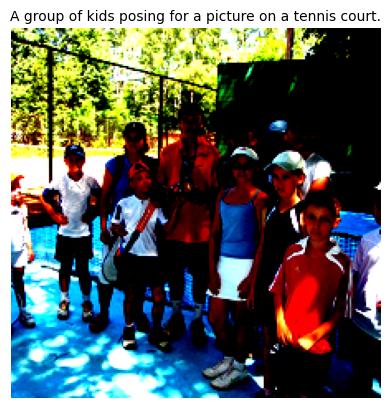

In [10]:
index = 44
show_sample(train_ds, index)

In [11]:
def collate_pair(batch):
    pixels = torch.stack([b["pixel_values"] for b in batch], dim=0)
    out = {"pixel_values": pixels, "captions": [b["caption"] for b in batch]}

    if ("input_ids" in batch[0]) and ("attention_mask" in batch[0]):
        out["input_ids"] = torch.stack([b["input_ids"] for b in batch], dim=0)
        out["attention_mask"] = torch.stack([b["attention_mask"] for b in batch], dim=0)
        labels = out["input_ids"].clone()
        labels[out["attention_mask"] == 0] = -100
        out["labels"] = labels
    return out

In [12]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_pair)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_pair)

 ---
 ## **モデルの構築**
シンプルなVLMモデルを構築します．<br>
CLIPの画像エンコーダを用いてエンコードした画像特徴（CLSトークン）をプロンプトの埋め込みと結合してLLM（本ノートブックではGPT-2）に入力します．LLMは画像特徴とプロンプトの情報から自己回帰的に次の単語を予測します．

 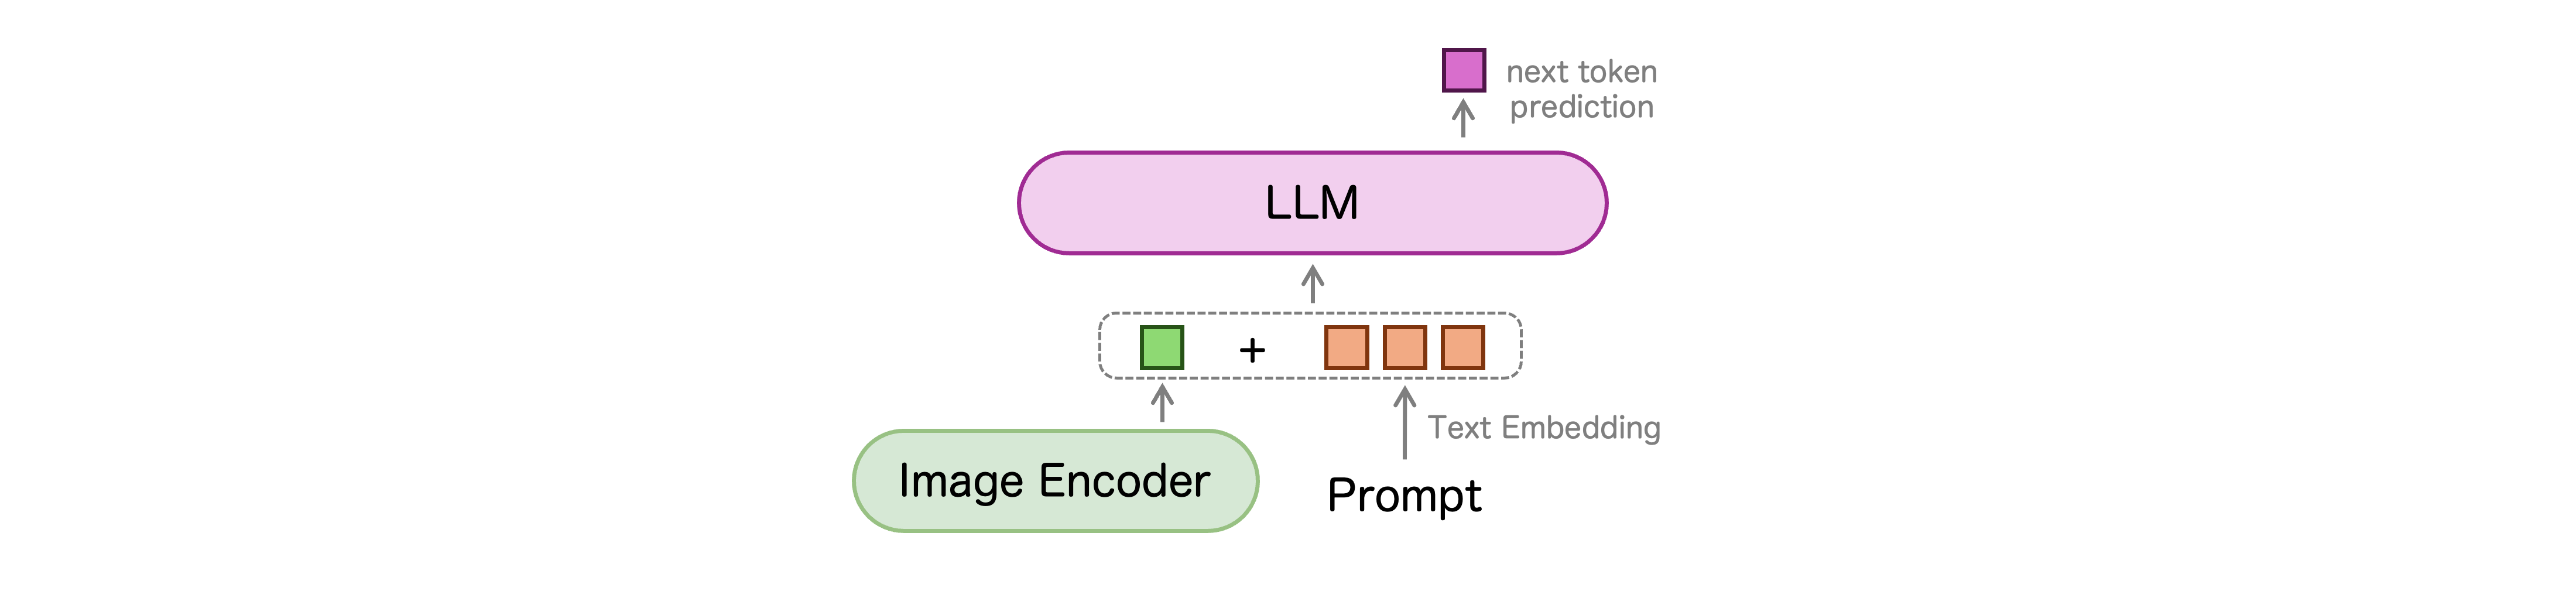

In [13]:
class SimpleVLM(nn.Module):
    def __init__(self, gpt2_model, image_encoder, tokenizer, freeze_clip=True, freeze_gpt=False):
        super().__init__()

        self.image_encoder = image_encoder.float().eval()

        self.gpt2 = gpt2_model
        self.pad_token_id = tokenizer.pad_token_id
        self.tokenizer = tokenizer

        self.proj = nn.Linear(768, 768)

        # 凍結オプション
        if freeze_clip:
            for p in self.image_encoder.parameters():
                p.requires_grad = False
        if freeze_gpt:
            for p in self.gpt2.parameters():
                p.requires_grad = False


    def forward(self, pixel_values, input_ids, attention_mask):
        B = pixel_values.size(0)

        img_feat = self.image_encoder(pixel_values)
        img_tok  = self.proj(img_feat).unsqueeze(1)           # [B,1,gpt2_dim]

        text_embeds   = self.gpt2.transformer.wte(input_ids)  # [B,L,gpt2_dim]
        inputs_embeds = torch.cat([img_tok, text_embeds], dim=1)

        img_mask = torch.ones(B, 1, device=attention_mask.device, dtype=attention_mask.dtype)
        attn_mask = torch.cat([img_mask, attention_mask], dim=1)

        labels = torch.cat([torch.full((B,1), -100, device=input_ids.device, dtype=input_ids.dtype),
                            input_ids], dim=1)

        return self.gpt2(inputs_embeds=inputs_embeds, attention_mask=attn_mask, labels=labels)

    def generate(self, pixel_values, prompt=""):
        self.eval()
        with torch.no_grad():
            img_tok = self.proj(self.image_encoder(pixel_values)).unsqueeze(1)
            if prompt:
                input_ids = self.tokenizer(prompt, return_tensors="pt").input_ids.to(pixel_values.device)
                text_embeds = self.gpt2.transformer.wte(input_ids)
                inputs_embeds = torch.cat([img_tok, text_embeds], dim=1)
            else:
                inputs_embeds = img_tok
            gen_ids = self.gpt2.generate(
                inputs_embeds=inputs_embeds,
                max_length=40,
                do_sample=True, top_p=0.9, temperature=0.7,
                pad_token_id=self.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
            )
        return gen_ids


---
## **学習**

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

model = SimpleVLM(gpt2_model, image_encoder, tokenizer=tokenizer, freeze_clip=True, freeze_gpt=False).to(device)

# 画像エンコーダは凍結、射影層 + GPT-2 を学習
optim = AdamW([p for p in model.parameters() if p.requires_grad], lr=2e-5, weight_decay=0.01)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def run_epoch(dataloader, train=True):
    model.train(train)
    total_loss, n = 0.0, 0
    pbar = tqdm(dataloader, desc="train" if train else "valid")
    for batch in pbar:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            out = model(pixel_values, input_ids, attention_mask)
            loss = out.loss

        if train:
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            optim.zero_grad(set_to_none=True)

        total_loss += loss.item() * pixel_values.size(0)
        n += pixel_values.size(0)
        pbar.set_postfix(loss=total_loss / n)

    return total_loss / n

EPOCHS = 2  # 小規模なのでまずは2エポック
best_val = float("inf")

for epoch in range(1, EPOCHS+1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss   = run_epoch(val_loader,   train=False)
    print(f"Epoch {epoch}: train {train_loss:.4f} | val {val_loss:.4f} | ppl {math.exp(val_loss):.2f}")

    if val_loss < best_val:
        best_val = val_loss
        os.makedirs("checkpoints", exist_ok=True)
        torch.save(model.state_dict(), "checkpoints/simple_vlm.pt")
        print(">> saved checkpoints/simple_vlm.pt")


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/tmp/ipython-input-901670712.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
train:   0%|          | 0/704 [00:00<?, ?it/s]/tmp/ipython-input-901670712.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
valid: 100%|██████████| 79/79 [00:59<00:00,  1.32it/s, loss=0.577]


Epoch 1: train 0.7909 | val 0.5770 | ppl 1.78
>> saved checkpoints/simple_vlm.pt


valid: 100%|██████████| 79/79 [00:59<00:00,  1.34it/s, loss=0.539]


Epoch 2: train 0.5716 | val 0.5390 | ppl 1.71
>> saved checkpoints/simple_vlm.pt


---
## **画像キャプションタスクにおける定量的評価**
生成したテキストが正解ラベルとして用意されたテキストとどれだけ一致しているのかを，自然言語処理で使われる一般的な評価指標で定量的に評価します．<br>
#### `BLEU`：生成文と参照文の n-gram（一致率） を測定する評価指標
- **計算方法**  
    1. **n-gram 精度**：参照文に含まれる n-gram の割合  
       $$
       p_n = \frac{\sum_{\text{ngram} \in \text{hyp}} \min\big(\text{count}_{\text{hyp}}(\text{ngram}), \ \text{count}_{\text{ref}}(\text{ngram})\big)}{\sum_{\text{ngram} \in \text{hyp}} \text{count}_{\text{hyp}}(\text{ngram})}
       $$
    2. **幾何平均**：複数の n-gram 精度を統合  
    3. **ブリービティペナルティ（BP）**：生成文が短すぎる場合に減点  

       $$
       \text{BP} =
       \begin{cases}
       1 & (c > r) \\
       e^{(1 - r/c)} & (c \le r)
       \end{cases}
       $$
       
    4. **BLEU-N の最終式**：  
       $$
       \text{BLEU-N} = BP \cdot \exp\left( \sum_{n=1}^{N} w_n \log p_n \right)
       $$


- 特徴
    - 長所：計算が速く、順序を考慮した一致度評価が可能
    - 短所：同義語や意味的類似は考慮できない

- 利用例
    - 画像キャプション評価では BLEU-4 がよく報告される
    - 他の指標（CIDEr, METEOR, SPICE）と併用されることが多い

In [15]:
# BLEU評価用にデータセットを作成
val_ds_for_bleu = COCODataset(
    "val_small.json",
    mode="multi", # ここをmultiにしてReferencesをリストとして取得できるようにする
    clip_preprocess=preprocess,
    tokenizer=tokenizer,
    max_length=64,
    return_path=True,
)

def simple_tokenize(s: str):
    return s.strip().lower().split()

In [16]:
refs_corpus, hyps_corpus = [], []

for i in tqdm(range(len(val_ds_for_bleu)), desc="BLEU: generating"):
    item = val_ds_for_bleu[i]

    # 入力画像
    pixel_values = item["pixel_values"].unsqueeze(0).to(device)

    # キャプション生成
    gen_ids = model.generate(
        pixel_values,
        prompt="A photo of"
    )
    hyp_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    # トークン化してコーパスへ追加
    hyps_corpus.append(simple_tokenize(hyp_text))
    refs_corpus.append([simple_tokenize(r) for r in item["captions"]])

# スムージングありでBLEU計算（高次n-gramが0になるのを回避）
smooth = SmoothingFunction().method4
bleu1 = corpus_bleu(refs_corpus, hyps_corpus, weights=(1.0, 0.0, 0.0, 0.0), smoothing_function=smooth)
bleu2 = corpus_bleu(refs_corpus, hyps_corpus, weights=(0.5, 0.5, 0.0, 0.0), smoothing_function=smooth)
bleu3 = corpus_bleu(refs_corpus, hyps_corpus, weights=(1/3, 1/3, 1/3, 0.0), smoothing_function=smooth)
bleu4 = corpus_bleu(refs_corpus, hyps_corpus, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

print(f"BLEU-1: {bleu1:.2f}")
print(f"BLEU-2: {bleu2:.2f}")
print(f"BLEU-3: {bleu3:.2f}")
print(f"BLEU-4: {bleu4:.2f}")

BLEU: generating: 100%|██████████| 500/500 [02:03<00:00,  4.04it/s]


BLEU-1: 42.01
BLEU-2: 22.25
BLEU-3: 10.69
BLEU-4: 5.94


## **画像キャプションタスクにおける定性的評価**

---- Image ----
val2017/000000021167.jpg
---- Ground Truth ----
A man and a women standing next to each other.
---- Generated ----
 a woman holding a skateboard.


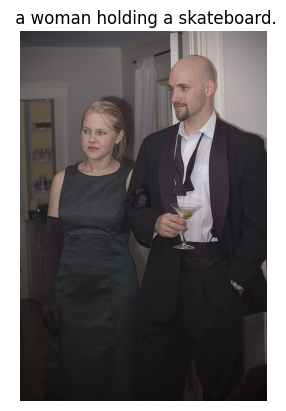

In [32]:
# 可視化したい index
idx = 77

# 入力（pixel_values）は Dataset から取得
batch_item = val_ds[idx]
pixel_values = batch_item["pixel_values"].unsqueeze(0).to(device)

# データセット内の生情報（画像パス/GTキャプション）を拾う
img_file = val_ds[idx]["image_path"]
gt_caption = val_ds[idx]["caption"]
img_path = os.path.join(img_file)

# 生成
with torch.no_grad():
    gen_ids = model.generate(pixel_values, prompt="A photo of")
gen_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

print("---- Image ----")
print(img_path)
print("---- Ground Truth ----")
print(gt_caption)
print("---- Generated ----")
print(gen_text)

# 画像表示（Colab）
from PIL import Image
import matplotlib.pyplot as plt
plt.imshow(Image.open(img_path))
plt.axis("off")
plt.title(gen_text)
plt.show()

 ## 課題
 1. adapter部分を単純な線形層から多層モデルに変更してみて精度を比較してみましょう
 2. その他の定量的評価指標を使って評価してみましょう